script to test gym env is working normally

In [1]:
import gym
import gym_BinPack3D
from gym_BinPack3D.envs import Box, Rotate
from stable_baselines3.common.env_checker import check_env
%matplotlib notebook

using random box sequence
Box to be sampled:
Box: Size 1 1 1 Position 0 0 0
Box: Size 5 2 4 Position 0 0 0


/home/ylchan/anaconda3/envs/binPack2/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:130: UserWarning: Your observation coming_boxes has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/home/ylchan/anaconda3/envs/binPack2/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:130: UserWarning: Your observation height_map has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


<IPython.core.display.Javascript object>


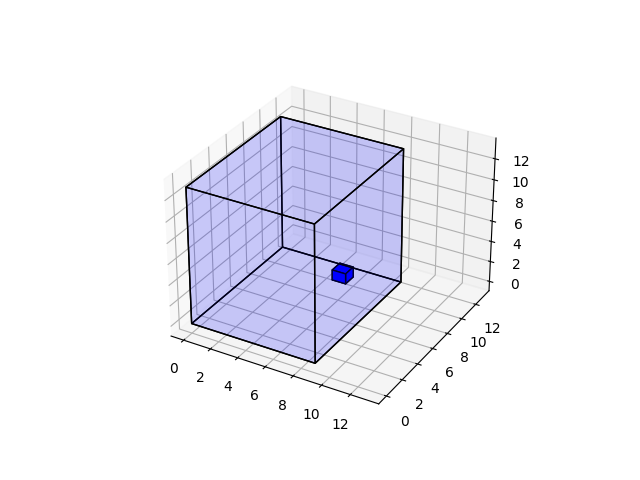

In [2]:
env = gym.make('BinPack3D-v0', 
                container_size = (9, 11, 13),
                boxSeqGenerator='random', 
                enabled_rotations = [Rotate.NOOP, Rotate.XY],
                n_foreseeable_box = 1,
                box_set = [Box(1,1,1), Box(5,2,4)]
            )
check_env(env, warn=True, skip_render_check=False)

using CUT-2 logic box sequence


<IPython.core.display.Javascript object>


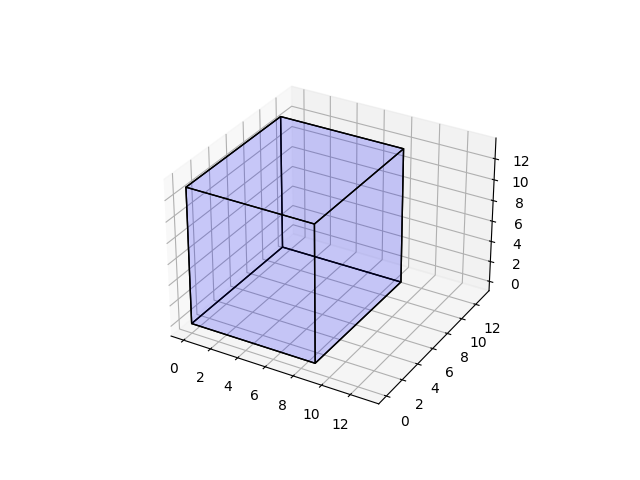

In [3]:
env = gym.make('BinPack3D-v0', 
                container_size = (9, 11, 13),
                boxSeqGenerator='CUT-2', 
                enabled_rotations = [Rotate.NOOP],
                n_foreseeable_box = 3,
                minSideLen = 2,
                maxSideLen = 5,
            )

check_env(env, warn=True, skip_render_check=False)

In [14]:
obs = env.reset()

<IPython.core.display.Javascript object>


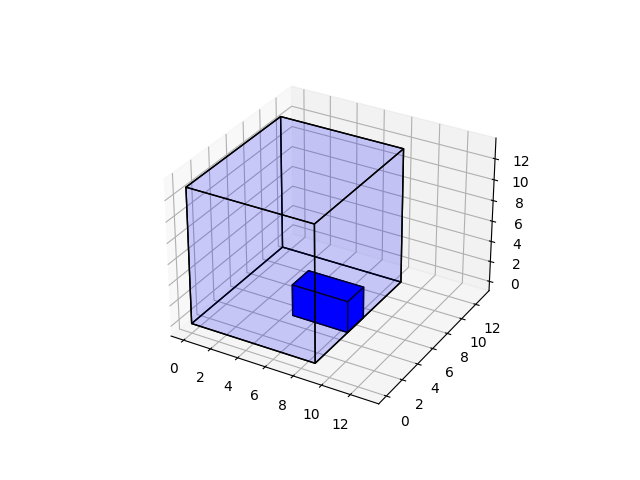

In [15]:
# we cheat to get correct pos to place box, by look at cut process info
box = env.boxSeqGenerator.next_N_boxes()[0]
pos = (box.x,box.y)
pos = env.position_to_actionIdx(pos)
rot = Rotate.NOOP
action = (pos, rot)

new_obs, reward, done, info = env.step(action)
fig = env.render()

In [ ]:
import imageio

In [ ]:
obs = env.reset()

with imageio.get_writer('cut2_seq.gif', mode='I') as writer:
    while True:
        # we cheat the game by look at cut process info and get the 
        # correct pos to place box, achieving perfect packing
        box = env.boxSeqGenerator.next_N_boxes()[0]
        pos = (box.x,box.y)
        pos = env.position_to_actionIdx(pos)
        rot = Rotate.NOOP
        action = (pos, rot)

        obs, reward, done, info = env.step(action)
        print(reward,done,info)
        fig = env.render("rgb_array")
        writer.append_data(fig)

        if done: break

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_parallelepiped(cube_definition, ax, color=None, showEdges=True):
    """
    Draw a 3D parallelepiped to a matplotlib 3d plot
    
    
    cube_definition: corner, plus 3 pts around that corner eg.
            [(0,0,0), (0,1,0), (1,0,0), (0,0,0.1)]
            
    ax: a matplotlib 3d axis obj i.e. from:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            
    modified from: https://stackoverflow.com/questions/44881885/python-draw-parallelepiped
    """
    if color is None: color = (0,0,1,0.1)
        
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]

    
    #ax = fig.add_subplot(111, projection='3d')
    edgecolors = 'k' if showEdges else (0,0,0,0)
    faces = Poly3DCollection(edges, linewidths=1, edgecolors=edgecolors)
    faces.set_facecolor(color)

    ax.add_collection3d(faces)

    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('auto')

In [ ]:
def plot_box(box, ax, color=None, showEdges=True):
    """
    box : obj of type Box
    
    ax: a matplotlib 3d axis obj i.e. from:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
    """
    dx, dy, dz = box.dx, box.dy, box.dz
    x,y,z = box.x, box.y, box.z
    
    cube_definition = [(x,y,z), 
                       (x+dx,y,z),
                       (x,y+dy,z),
                       (x,y,z+dz),
                      ]
    #print (cube_definition)
    plot_parallelepiped(cube_definition, ax, color, showEdges)

In [ ]:
def show_env(env):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')



    maxSideLen = max(env.container_size)
    box = Box(maxSideLen,maxSideLen,maxSideLen)
    plot_box(box, ax, color=(0,0,0,0), showEdges=False) # invisible bound box
    
    box = Box(*env.container_size)
    plot_box(box, ax)
    
    for box in env.container.boxes[:-1]:
        plot_box(box, ax, color=(0,0.5,1,1))
    
    box = env.container.boxes[-1]
    plot_box(box, ax, color=(0,0.,1,1))
    
    return fig
    
    


In [ ]:
fig = show_env(env)